# Diffusion-TS Tutorial

## Diffusion-TS: Interpretable Diffusion for General Time Series Generation

This notebook describes the user-guide of a time-series synthetic data generation application using Diffusion-TS framework.

## Necessary packages and functions call

In [1]:
import os
import torch
import numpy as np

from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

/home/stelios-pc/anaconda3/envs/Diffusion/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting and Training

### Build dataset and settings

In [2]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = './Config/energy.yaml'
        self.save_dir = './energy_results'
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = build_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

### Training models

In [3]:
trainer.train()

loss: 0.050657: 100%|██████████| 25000/25000 [25:19<00:00, 16.45it/s]

training complete


## Inference and Visualizations

### Sampling

In [4]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
# ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_train.npy"))
ori_data = np.load(os.path.join(dataset.dir, f"energy_norm_truth_{seq_length}_train.npy"))  # Uncomment the line if dataset other than Sine is used.
# test_data = np.load(os.path.join(dataset.dir, f"energy_norm_truth_{seq_length}_test.npy"))
fake_data = trainer.sample(num=len(dataset), size_every=512, shape=[seq_length, feature_dim])

sampling loop time step: 100%|██████████| 1000/1000 [01:06<00:00, 15.07it/s]


In [5]:
if dataset.auto_norm:
    # np.save(os.path.join(args.save_dir, f'ddpm_fake_energy_negative1_to1.npy'), fake_data)
    fake_data = unnormalize_to_zero_to_one(fake_data)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_energy_0_to_1'), fake_data)
    raw_data = dataset.scaler.inverse_transform(fake_data.reshape(-1, fake_data.shape[-1]))
    raw_data = raw_data.reshape(fake_data.shape)
    print(raw_data.shape)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_energy_raw'), raw_data)

(2048, 49, 57)


### Visualization

We visualize the original and synthetic data distributions using PCA, tSNE and Density analysis.

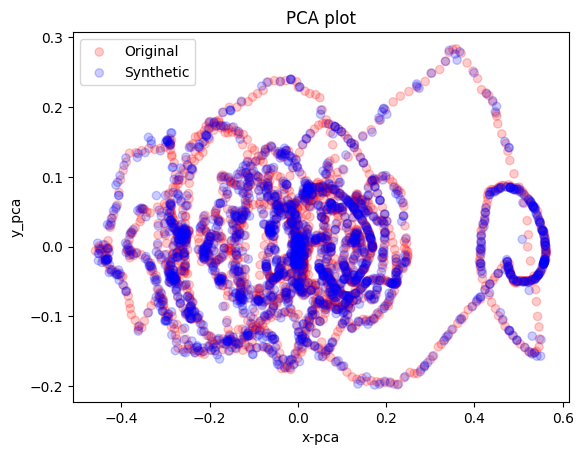

In [6]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='pca', compare=ori_data.shape[0])

/home/stelios-pc/anaconda3/envs/Diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/stelios-pc/anaconda3/envs/Diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3798 samples in 0.000s...
[t-SNE] Computed neighbors for 3798 samples in 0.198s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3798
[t-SNE] Computed conditional probabilities for sample 2000 / 3798
[t-SNE] Computed conditional probabilities for sample 3000 / 3798
[t-SNE] Computed conditional probabilities for sample 3798 / 3798
[t-SNE] Mean sigma: 0.052607
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.811615
[t-SNE] KL divergence after 300 iterations: 1.554500


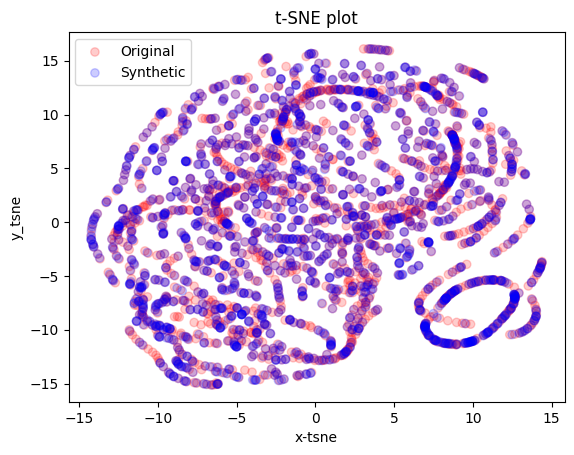

In [7]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='tsne', compare=ori_data.shape[0])

/home/stelios-pc/Desktop/PhD/PhD/Diffusion Models/Code/Diffusion-TS/Utils/metric_utils.py:157: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
/home/stelios-pc/Desktop/PhD/PhD/Diffusion Models/Code/Diffusion-TS/Utils/metric_utils.py:158: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions

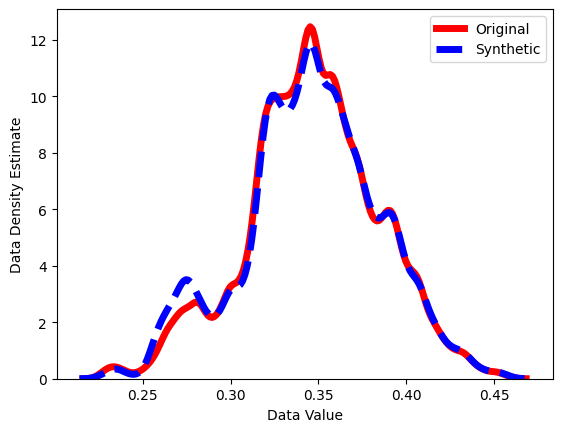

In [8]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='kernel', compare=ori_data.shape[0])

# Load the -1 to 1 gen data, and denormalize

In [9]:
fake_data_denorm = np.load('./energy_results/ddpm_fake_energy_negative1_to1.npy')
min_val = dataset.scaler.data_min_ 
max_val = dataset.scaler.data_max_
fake_data_denorm = ((fake_data_denorm + 1) / 2) * (max_val - min_val) + min_val

FileNotFoundError: [Errno 2] No such file or directory: './energy_results/ddpm_fake_energy_negative1_to1.npy'

# Reconstruct the original dataframe with the gen data

In [ ]:
# Save the generated data to the original dataframe format
import pandas as pd
original_df = pd.read_csv("./Data/datasets/energy_data.csv")
original_columns = original_df.columns.tolist()
df = pd.DataFrame(fake_data_denorm[0], columns=original_columns)
df.to_csv(os.path.join(args.save_dir, 'gen_data.csv'), index=False)

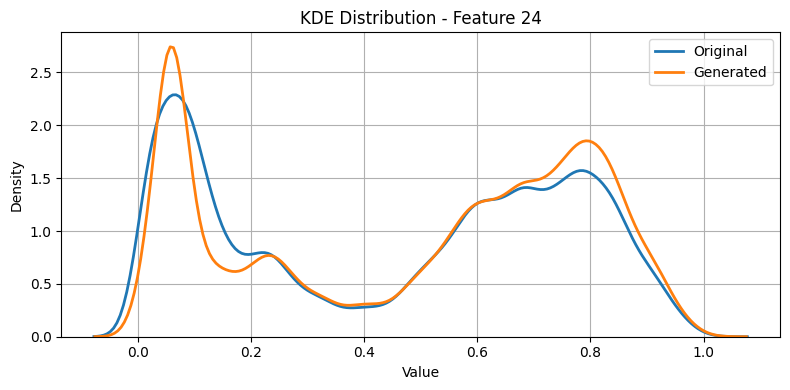

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten time and batch dimensions
ori_flat = ori_data.reshape(-1, ori_data.shape[-1])
fake_flat = fake_data.reshape(-1, fake_data.shape[-1])


plt.figure(figsize=(8, 4))
sns.kdeplot(ori_flat[:, 100], label='Original', linewidth=2)
sns.kdeplot(fake_flat[:, 100], label='Generated', linewidth=2)
plt.title(f'KDE Distribution - Feature {23+1}')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()